In [2]:
import numpy as np
import dynesty
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner

[[0.59677897 0.         0.         ... 0.         0.         0.        ]
 [0.         0.9210494  0.         ... 0.         0.         0.        ]
 [0.         0.         1.15618395 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 9.44160018 0.         0.        ]
 [0.         0.         0.         ... 0.         9.80764198 0.        ]
 [0.         0.         0.         ... 0.         0.         9.85559786]]


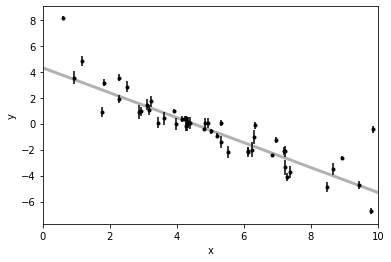

In [3]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N) # I guess this is just some random number?
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr,fmt='.k', capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

print(np.diag(x))

In [4]:
## Maximum Likelihood Estimation
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [5]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


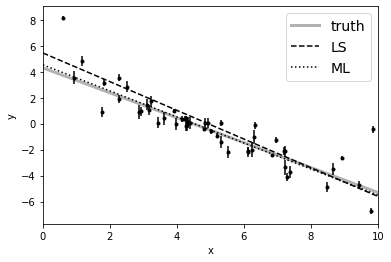

In [6]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [12]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

print(pos)
print(soln.x.shape)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
# sampler.run_mcmc(pos, 5000, progress=True);

[[-1.00296999  4.52822592 -0.79042497]
 [-1.0030027   4.52820001 -0.79040456]
 [-1.00295244  4.52842261 -0.79033496]
 [-1.00314629  4.52822052 -0.79038884]
 [-1.00295714  4.52836581 -0.79005507]
 [-1.00295143  4.52842786 -0.79034494]
 [-1.00294338  4.52828278 -0.79036444]
 [-1.0030858   4.52829062 -0.79048888]
 [-1.00300033  4.52854577 -0.79062707]
 [-1.00293989  4.52815304 -0.79048753]
 [-1.00289962  4.52832073 -0.79054811]
 [-1.00308005  4.52838227 -0.79051338]
 [-1.00298687  4.52831886 -0.7905055 ]
 [-1.00279412  4.5283777  -0.79064285]
 [-1.00298987  4.52824813 -0.7903551 ]
 [-1.00308777  4.52830283 -0.79038984]
 [-1.00292194  4.52819428 -0.79047379]
 [-1.00305601  4.52824897 -0.79026379]
 [-1.00296802  4.52818822 -0.79034855]
 [-1.0027963   4.52841755 -0.79059228]
 [-1.00305694  4.528441   -0.79051111]
 [-1.00296414  4.52839177 -0.79053303]
 [-1.00301447  4.52799018 -0.79054278]
 [-1.00303378  4.52818953 -0.7902771 ]
 [-1.00315153  4.5282703  -0.79042727]
 [-1.00286439  4.52817072

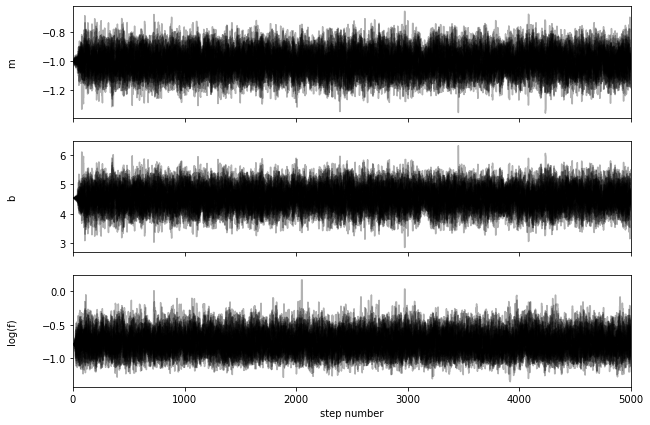

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(10432, 3)


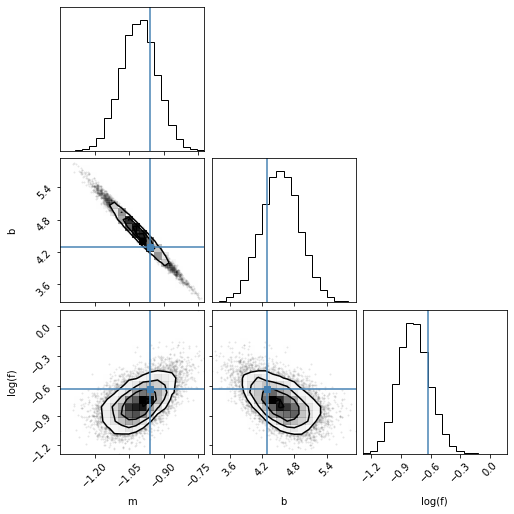

In [9]:
# inds = np.random.randint(len(flat_samples), size=100)
# for ind in inds:
#     sample = flat_samples[ind]
#     plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [10]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>